In [8]:
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph
from langchain_openai import ChatOpenAI
from IPython.display import Image, Markdown
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
class SubState(TypedDict):
    input_text: str
    translated_text: str

In [4]:
subgraph_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [34]:
def translate_text(state: SubState) -> SubState:
    prompt = f"""
        Translate the following text to Roman Urdu.
        Keep it natural and clear. Do not add extra content.

        Text:
        {state["input_text"]}
    """.strip()

    response = subgraph_llm.invoke(prompt).content
    return { 'translated_text' : response }

In [35]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node("translate", translate_text)

subgraph_builder.add_edge(START, "translate")
subgraph_builder.add_edge("translate", END)

subgraph = subgraph_builder.compile()

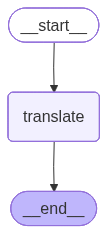

In [36]:
Image(subgraph.get_graph().draw_mermaid_png())

In [51]:
sections = []
for key, value in subgraph.invoke({"input_text": "Hello, how are you?"}).items():
    sections.append(f"### **{key.capitalize()}**\n{value}\n")

output_text = "\n---\n".join(sections)
display(Markdown(output_text))

### **Input_text**
Hello, how are you?

---
### **Translated_text**
Hello, aap kaise hain?


In [38]:
class ParentState(TypedDict):
    
    question: str
    answer_eng: str
    answer_roman: str

In [39]:
parent_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [44]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [45]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_roman': result['translated_text']}

In [46]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

In [49]:
graph = parent_builder.compile()

In [50]:
final_state = graph.invoke({'question': 'What is quantum physics'})

sections = []
for key, value in final_state.items():
    sections.append(f"### **{key.capitalize()}**\n{value}\n")

output_text = "\n---\n".join(sections)
display(Markdown(output_text))

### **Question**
What is quantum physics

---
### **Answer_eng**
Quantum physics is a branch of physics that studies the behavior of particles at the smallest scales, such as atoms and subatomic particles. It deals with phenomena that are not explained by classical physics, such as wave-particle duality, superposition, and entanglement.

---
### **Answer_roman**
Quantum physics woh shakh hai jis mein choti se choti paimanon jaise atoms aur subatomic particles ke rawayat ka mutalia hota hai. Is mein aise phenomena shamil hote hain jo classical physics se samjha nahi ja sakte, jaise wave-particle duality, superposition, aur entanglement.
